4.321229199999999


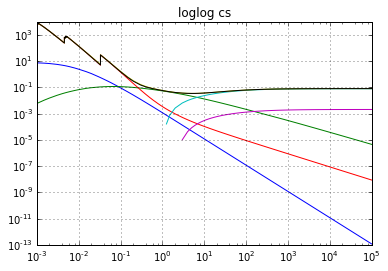

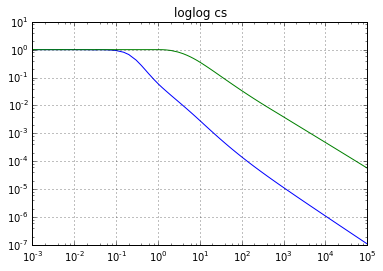

In [364]:
# -*- coding: utf-8 -*-

'''
moc^2 = rest energy of electron = 511 keV
tita  = angle between incident and scattered gamma rays

planck constant
h = 6.62606957 × 10-34 m2 kg / s
h =  4.135667516 x 10-15 eV*s
c = 299792458 m / s

1 J = 6241509647120.4 MeV
1 eV = 1.602176487E-19 J
1 MeV = 1.602176487E-13 J

E = hc/wavelength
freq = c/wavelength


Compton wavelength: h/mec = 2.43 x 10-12 m comptonWl
me: masa del electron
    9.10938215(45)×10−31 Kg
re: radio del electrón
    2.818x10-15 m


1 barn = 10-28 m2 = 10-24 cm2

'''

class Units:
    comptonWl =  2.43e-12
    c = 299792458
    hmk = 6.62606957e-34
    hev = 4.135667516e-15
    me =  9.10938215e-31
    re = 2.818e-15
    rec = 2.818e-13
    barn = 10e-28 #m2
    re2 = re * re # m2
    


import numpy as np
import matplotlib.pyplot as plt
import csv


%matplotlib inline


def compton_energy(angle, E): # E en MeV
    return E / (1 + (E/0.511) * (1 - np.cos(angle)))

def kn_kn(angle, E): # E en MeV
    x = 1 - np.cos(angle)
    alpha = E / .511
    y = 1 + alpha * x
    z = y ** (-2)
    w = 1 + np.cos(angle) ** 2
    
    return ((Units.rec ** 2/2) * z * (w + ((alpha * x) ** 2)/y))


def compton_interaction(compton_matrix):

    N = compton_matrix.shape[1]
    compton_interaction = np.empty((3,0))

    estado_temp = np.copy(compton_matrix)
    while N > 0:
        # generacion de ángulos aleatorios
        angulos = np.random.random(size=compton_matrix.shape[1]) * 2 * np.pi
    
        # asignacion de ángulos aleatorios 
        compton_matrix[2:3] = angulos

        # generacion de densidades aleatorias
        densidades  = np.random.random(size=compton_matrix.shape[1])

        # saco energía de matríz de estado
        energia = compton_matrix[0:1,:]

        # se calcula la densidad con klein nishina
        dcs_10 = kn_kn(angulos, energia )/ (Units.rec **2)

        # determino las posiciones aceptadas
        accept = dcs_10 < densidades
    
        compton_interaction = np.hstack((compton_interaction, compton_matrix[0:3,accept[0]]))
        compton_matrix = np.delete(compton_matrix, np.nonzero(accept[0]), axis=1)
             

        #print (compton_interaction)
        N =  compton_matrix.shape[1]
    ce = compton_energy(compton_interaction[2:3,], compton_interaction[0:1,])
    compton_interaction[0:1] = ce
    return(compton_interaction)


### Datos para el INa
#### I: Z = 53 %W 0.84627 dens 4.93 g/cm3
#### Na: Z = 11 %W 0.153373 dens 0.97 g/cm3
#### NaI: dens = 4.3224 g/cm3


densNa = 0.97
pcNa = 0.15373
densI  = 4.93
pcI = 0.84627
densNaI = densNa * pcNa + densI * pcI
print(densNaI)


rows=[]

with open('xcom_ina.pl') as csvfile:
    reader = csv.DictReader(csvfile,delimiter='|')
    for row in reader:
        # http://stackoverflow.com/questions/14813396/python-elegant-way-to-delete-empty-lists-from-python-dict
        rows.append({k:v for k,v in row.items() if v})

reader.fieldnames = reader.fieldnames[:-1]        
n_fields = len(reader.fieldnames)
n_data = len(rows)

import numpy as np

cs = np.zeros(n_fields * n_data).reshape(n_data, n_fields)

i = 0
for r in rows:
    cs[i] = np.asarray([r[f] for f in reader.fieldnames])
    i = i + 1


energy = cs[:,0]
total_cross_section  = cs[:,7]
mean_free_path_cs = 1/(total_cross_section * densNaI)
photo_absortion_cs = cs[:,3]
pair_production_nuclear_cs = cs[:,4]
pair_production_atom_cs = cs[:,5]
compton_cs = cs[:,2]

# pares + photo + compton
#mu_total = pair_production_nuclear_cs + photo_absortion_cs + compton_cs 

# log x and y axis
plt.subplot(111)
for i in range(1, n_fields):
    plt.loglog(cs[:,0], cs[:,i], basex=10)

plt.grid(True)
plt.title('loglog cs')   

plt.show()

p_photo_e = photo_absortion_cs / total_cross_section
p_photo_compton_e = (photo_absortion_cs + compton_cs) / total_cross_section

# log x and y axis
plt.subplot(111)
plt.loglog(energy, p_photo_e, basex=10)
plt.loglog(energy, p_photo_compton_e)

plt.grid(True)
plt.title('loglog cs')   

plt.show()

In [375]:
N = 100000
H = 4.5
Einic = .662

photo_matrix = np.empty((3,0))
pair_matrix = np.empty((3,0))
# Energia: Fila 0, energía inicial Einic
# Posición: Fila 1, posición inicial x = 0
# Dirección: Fila 2, dirección inicial theta = 0
Estado = np.zeros(3*N).reshape(3,N)
Estado[0:1,] = np.ones(N) * Einic # Mev


def ph_cp_pr(Estado):
    global photo_matrix
 
    global pair_matrix
    
    N = Estado.shape[1]
    
    while N > 0:
        
        # Cálculo del camino libre medio
        mean_free_path = np.interp(Estado[0:1,], energy, mean_free_path_cs)
        # determina la nueva posición con la posición anterior
        Estado[1:2,] = Estado[1:2,] + mean_free_path * np.cos(Estado[2:3])

        print("estado pre", Estado.shape[1], Estado[1:2,].max())
        
        # Determina si el fotón abandonó el volumen del detector
        m = (Estado[1:2,] <= H)
        Estado = Estado[0:3, (m == 1)[0]]
        
        print("estado after", Estado.shape[1], Estado[1:2,].max())
        
        # Obtiene los eventos por
        #     Absorción fotoeléctrica
        #     Interacción Compton
        #     Formación de pares
        R = np.random.random(size = Estado.shape[1])
        p_photo = np.interp(Estado[0:1,], energy, p_photo_e)
        p_photo_compt = np.interp(Estado[0:1,], energy, p_photo_compton_e)
                
        #  determinacion de  los fotones para photo
        a = (R <= p_photo) 

        photo_matrix = np.hstack((photo_matrix, Estado[0:3,a[0]]))

        #  determinacion de  los fotones para compton
        b = (R > p_photo)
        c = (R <= p_photo_compt)
        d = (b & c)
        
        
        compton_matrix =  Estado[0:3,d[0]]

        # determinacion de los fotones para pares
        e = R > p_photo_compt
        pair_matrix = np.hstack((pair_matrix, Estado[0:3,e[0]]))
        
        Estado = compton_interaction(compton_matrix)
        N =  Estado.shape[1]

ph_cp_pr(Estado)



estado pre 100000 3.11271865502
estado after 100000 3.11271865502
estado pre 87922 6.22342245732
estado after 76480 4.49982213226
estado pre 34137 6.63188356451
estado after 32191 4.49987768384
estado pre 7234 5.52233471991
estado after 7013 4.49764639578
estado pre 912 5.04652452598
estado after 899 4.49806222734
estado pre 77 4.41854542424
estado after 77 4.41854542424
estado pre 3 4.24974441594
estado after 3 4.24974441594
estado pre 1 3.35995833688
estado after 1 3.35995833688


In [376]:
photo_matrix.shape, compton_matrix.shape, pair_matrix.shape

((3, 86359), (3, 0), (3, 19))

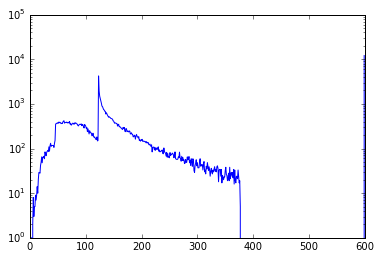

In [377]:
hist = np.histogram(photo_matrix[0:1,], bins=600)
#hist[0][0:20] = 0

plt.yscale('log')
plt.plot(hist[0])